In [7]:
import rospy
from robotics_demo.msg import JointPositions, Observation, AchievedGoal, PositionCommand, RPYProprioState, Velocities, ResetInfo, Reengage
from robotics_demo.srv import getIK, getIKResponse, getState, getStateResponse
import time

In [8]:
import numpy as np
import os, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
print("current_dir=" + currentdir)
os.sys.path.insert(0, currentdir)
from utils import rosImg_to_numpy, proprio_quat_to_rpy_vector, \
        proprio_rpy_to_ROSmsg, ag_to_vector, ag_to_ROSmsg,\
        proprio_rpy_to_rpy_vector, unstack, act_to_jointPositionsROSmsg

current_dir=/catkin_ws/src/unity_robotics_env/robotics_demo/scripts


In [9]:
# The publisher which sends out position commands that then get converted to joint commands by the IK node
pos_cmd_pub = rospy.Publisher('xyz_rpy_g_command', PositionCommand, queue_size=1)
# The publisher which resets the non_arm elements of the state
env_reset_pub = rospy.Publisher('full_reset', ResetInfo, queue_size=1)
env_reEngage_physics_pub = rospy.Publisher('re_engage_physics', Reengage, queue_size=1)
env_reEngage_collision_pub = rospy.Publisher('re_engage_collision', Reengage, queue_size=1)
# service to get IK 
IK = rospy.ServiceProxy('get_IK', getIK)
getStateServ = rospy.ServiceProxy('getState', getState)

In [10]:
# First things first, lets load some data! 
DATA_PATH = os.getcwd()[:-(len("/unity_robotics_env/robotics_demo/scripts"))]+'/data/UR5/'
OBS_ACT_PATH = DATA_PATH+'obs_act_etc/'
IMS_PATH = DATA_PATH+'states_and_ims/'
TIME_FREQUENCY = 15
default_vr_controller_pos =  RPYProprioState(-0.4, 0.2, 0.0,0.0,0.0,0.0,0.0)

In [11]:
rospy.init_node('jupyter')

In [12]:

    
def process_observation():
    '''
    The full state will be sent out at Nh > controlHz by the env, listen to it, and save the relevant parts
    '''

    o = getStateServ(int(1)).state
    proprioceptive_state  = proprio_quat_to_rpy_vector(o.proprio)
    achieved_goal = ag_to_vector(o.ag)
    full_state = np.concatenate([proprioceptive_state, achieved_goal])
    # process the images
    shoulder_image  = rosImg_to_numpy(o.shoulderImage)
    gripper_image = rosImg_to_numpy(o.gripperImage)
    return proprioceptive_state, achieved_goal, shoulder_image, gripper_image


def check_reset_convergence(proprio, ag, current_proprio, current_ag, threshold = 0.01):
    proprio_checks = abs(proprio - current_proprio) < threshold
    ag_checks = abs(ag-current_ag) < threshold
    all_checks = np.concatenate([proprio_checks, ag_checks])
    return all_checks
#     if np.all(all_checks):
#         return True
#     else:
#         return False
    
def converge_on_reset(proprio, ag, threshold = 0.05):
    t_start = time.time()
    r = rospy.Rate(10) # 10hz 
    while not rospy.is_shutdown():
        t = time.time()
        current_arm, current_ag, _,_ = process_observation()
        checks = check_reset_convergence(proprio, ag, current_arm, current_ag, threshold)
        if (t > t_start+0.2):
            print(checks)
            return
        elif np.all(checks):
            return
        r.sleep() # ros sleep for a little while before checking convergence again
    

In [13]:
test = np.load(f"{OBS_ACT_PATH}/5/data.npz", allow_pickle=True)
obs, acts, ags, times = test['obs'], test['acts'], test['achieved_goals'], test['times']
proprio = obs[:, :7]
print(len(acts))

1747


In [14]:


def reset_to(arm, ag, prev_act = np.zeros(7)):
    
    arm_msg = proprio_rpy_to_ROSmsg(arm)
    prev_act = act_to_jointPositionsROSmsg(prev_act)
    # Get IK for actual position
    joints = IK(arm_msg, prev_act).joints
    # Package into ResetInfo
    r = ResetInfo(joints, ag_to_ROSmsg(ag), Velocities())
    # Send down
    env_reset_pub.publish(r)
    converge_on_reset(arm, ag, threshold = 0.05)
    env_reEngage_collision_pub.publish(Reengage())
    time.sleep(1/TIME_FREQUENCY)
    
    

In [24]:
i = 990
#p[-1] = 1.0
reset_to(proprio[i,:], ags[i,:], acts[i,:])

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


In [22]:
for i in range(947, 1200):
    reset_to(proprio[i,:], ags[i,:], acts[i,:])

[ True  True False  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True False  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True False  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True False  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True False  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True  True  True  True  True  True 

KeyboardInterrupt: 

In [27]:
env_reEngage_physics_pub.publish(Reengage())
t0 = time.time()
next_time = t0 + 1/TIME_FREQUENCY
while not rospy.is_shutdown() and i < len(acts):
    t = time.time()
    if t >= next_time:
        # Triggers corelogic acting
        try:
            next_time = next_time + 1/TIME_FREQUENCY
            pos_cmd_pub.publish(proprio_rpy_to_ROSmsg(acts[i,:]))
            i += 1
        except Exception as e:
            print(e)
            break

KeyboardInterrupt: 

In [62]:
#env_reEngage_pub.publish(Reengage())
r = rospy.Rate(TIME_FREQUENCY) # 15hz 
while not rospy.is_shutdown() and i < len(acts):
    try:
        pos_cmd_pub.publish(proprio_rpy_to_ROSmsg(acts[i,:]))
        #env_reset_pub.publish(ag_to_ROSmsg(ags[i,:])) # shape (7,)
        i += 1
        print(i)
    except Exception as e:
        print(e)
        break
    r.sleep() # ros sleep for a little while before checking convergence again

901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120

KeyboardInterrupt: 

In [21]:
import time
for i in range(800, len(proprio)):
    reset_to(proprio[i,:], ags[i,:])
    time.sleep(0.04)

KeyboardInterrupt: 

In [35]:
proprio_rpy_to_ROSmsg(proprio[idx,:])

pos_x: -0.4428572952747345
pos_y: 0.22392550110816956
pos_z: 0.4295077919960022
rot_r: 0.6223673820495605
rot_p: -0.22585928440093994
rot_y: -0.1272006332874298
gripper: 0.9654262661933899

In [12]:
idx = 140
pos_cmd_pub.publish(proprio_rpy_to_ROSmsg(proprio[idx,:]))

In [70]:
times[0]

{'timestep': 49859,
 'data_arrival_time': 1617545058.4919775,
 'model_processed_time': 1617545058.5428803,
 'beat_sent_time': 1617545058.5368078,
 'act_begin_time': 1617545058.5428731}

In [55]:
# What we can do is say the beat sent time is the 'centre', thats 0
# then the order should be data_arrival, beat_sent, act_begin, model_processed
# therefore we can create a histogram for each of these around 0
da, ab, mp = [], [], []

for t in times:
    beat = t['beat_sent_time']
    da.append(t['data_arrival_time']- beat)
    #bs.append(beat)
    ab.append(t['act_begin_time'] - beat)
    mp.append(t['model_processed_time'] - beat)
    
bs = []
for i in range(0,len(times)-1):
    bs.append(times[i+1]['beat_sent_time'] - times[i]['beat_sent_time'])
    


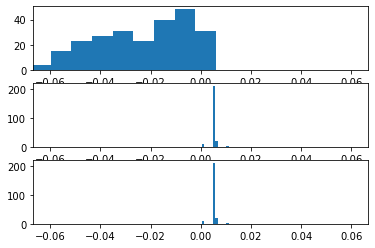

In [63]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3)
left, right = -1/TIME_FREQUENCY, 1/TIME_FREQUENCY
axs[0].hist(da)
axs[1].hist(ab)
axs[2].hist(mp)

for i in range(0,len(axs)):
    axs[i].set_xlim(left=left, right=right)
    

(array([  2.,   0.,   3.,   2.,  46., 182.,   2.,   3.,   0.,   2.]),
 array([0.06659007, 0.06660538, 0.06662068, 0.06663599, 0.0666513 ,
        0.0666666 , 0.06668191, 0.06669722, 0.06671252, 0.06672783,
        0.06674314]),
 <a list of 10 Patch objects>)

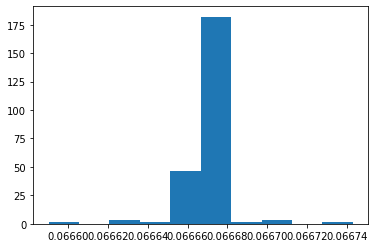

In [64]:
plt.hist(bs)